In [23]:
import numpy as np
import pandas as pd
import scipy.sparse
import pickle
import xgboost as xgb

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

from pylab import rcParams
rcParams['figure.figsize'] = 8,5


pd.set_option('precision', 10)
def convert_date(df):
    df['actual_date'] = df['actual_date'].astype('datetime64[ns]')


target_minT = pd.read_csv('./date/31088_103.csv')
X_train = pd.read_csv('./date/character_31088.csv')
X_train = X_train.drop(['point_id'],axis=1)

# test = pd.read_csv("test.csv")
# test = test.drop(['ID'],axis=1)

convert_date(X_train)
convert_date(target_minT)

target_minT.set_index('actual_date', inplace=True)

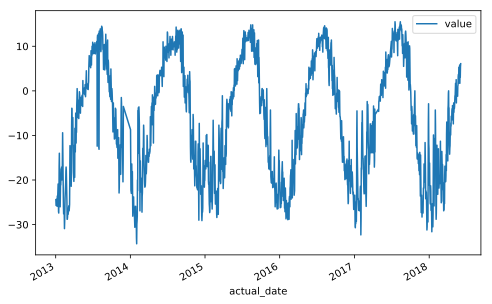

In [24]:
target_minT.sort_values('actual_date', ascending=True).plot()

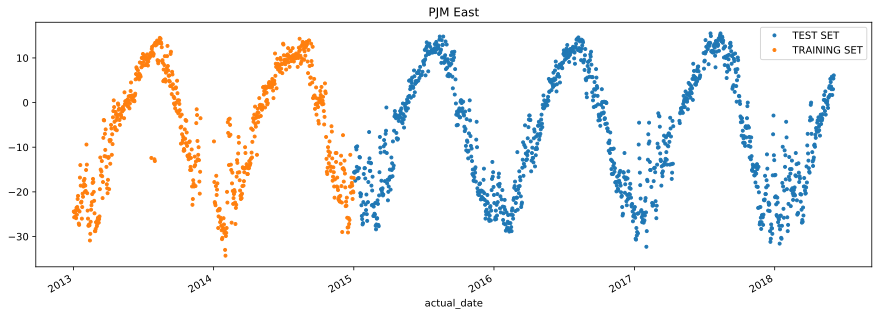

In [29]:

split_date = '01-Jan-2015'
pjme_train = target_minT.loc[target_minT.index <= split_date].copy()
pjme_test = target_minT.loc[target_minT.index > split_date].copy()

_ = pjme_test \
    .rename(columns={'value': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'value': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

In [31]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X_train, y_train = create_features(pjme_train, label='value')
X_test, y_test = create_features(pjme_test, label='value')

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

/usr/lib/python3.7/site-packages/xgboost-0.81-py3.7.egg/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/lib/python3.7/site-packages/xgboost-0.81-py3.7.egg/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

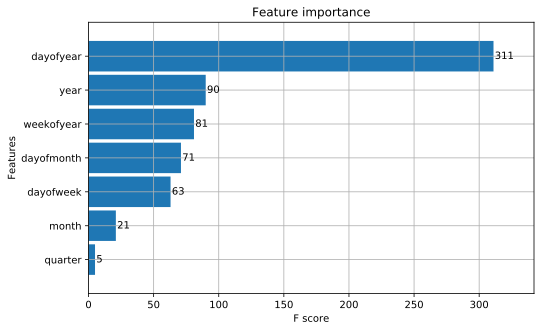

In [33]:
# This is a metric that simply sums up how many times each feature is split on.
_ = xgb.plot_importance(reg, height=0.9)

In [34]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

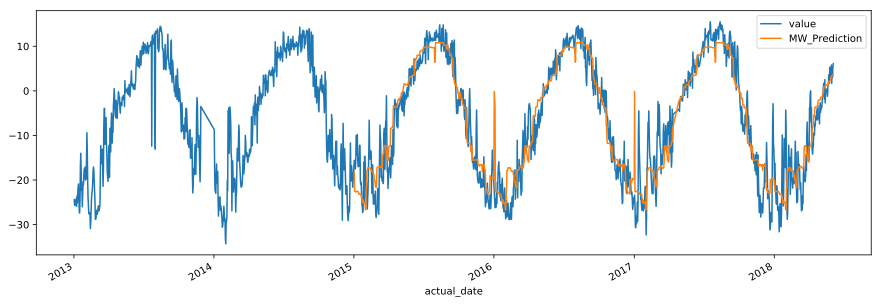

In [36]:
_ = pjme_all[['value','MW_Prediction']].plot(figsize=(15, 5))

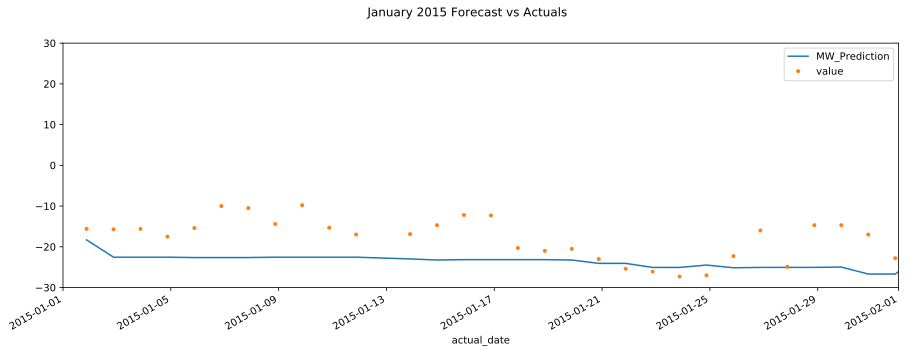

In [39]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','value']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(-30, 30)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

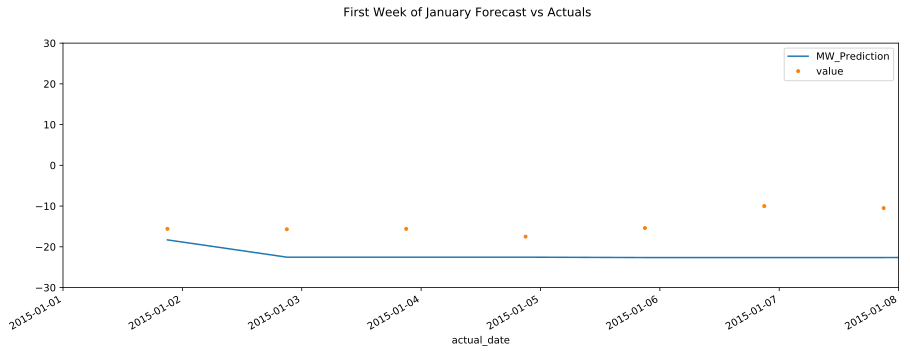

In [41]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','value']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(-30, 30)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

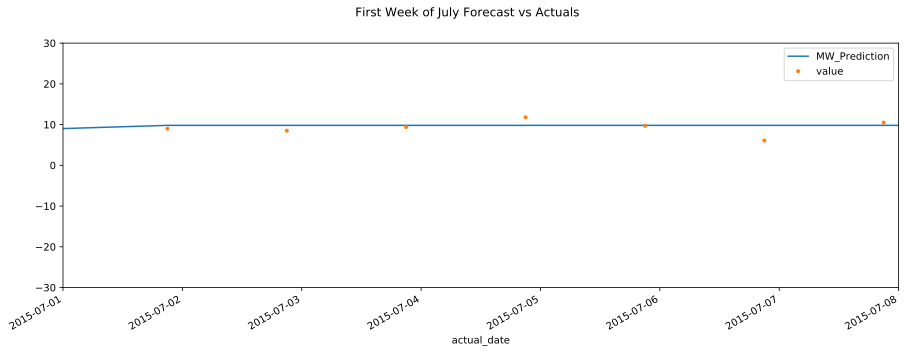

In [42]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','value']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(-30, 30)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mean_squared_error(y_true=pjme_test['value'],
                   y_pred=pjme_test['MW_Prediction'])

22.162709746440463

In [45]:
mean_absolute_error(y_true=pjme_test['value'],
                   y_pred=pjme_test['MW_Prediction'])

3.4905444564858903

In [46]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['value'],
                   y_pred=pjme_test['MW_Prediction'])

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


inf

In [48]:
pjme_test['error'] = pjme_test['value'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['value','MW_Prediction','error','abs_error']]

# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

value  MW_Prediction          error      abs_error
year month dayofmonth                                                    
2017 1     1           -23.4  -0.1521088481 -23.2478911519  23.2478911519
2016 1     3           -26.2  -3.4585335255 -22.7414664745  22.7414664745
           1           -22.5  -0.1521088481 -22.3478911519  22.3478911519
2017 11    26          -28.3 -16.5610580444 -11.7389419556  11.7389419556
2016 2     9           -28.9 -17.3212203979 -11.5787796021  11.5787796021
           11          -28.8 -17.2311553955 -11.5688446045  11.5688446045
2015 4     13          -14.7  -3.3977978230 -11.3022021770  11.3022021770
2016 2     8           -28.5 -17.3212203979 -11.1787796021  11.1787796021
2015 4     6           -19.5  -8.3775663376 -11.1224336624  11.1224336624
2016 2     10          -28.4 -17.3212203979 -11.0787796021  11.0787796021

In [49]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

value  MW_Prediction          error      abs_error
year month dayofmonth                                                    
2017 1     1           -23.4  -0.1521088481 -23.2478911519  23.2478911519
2016 1     3           -26.2  -3.4585335255 -22.7414664745  22.7414664745
2018 1     30           -4.3 -26.6887817383  22.3887817383  22.3887817383
2016 1     1           -22.5  -0.1521088481 -22.3478911519  22.3478911519
2018 1     31           -7.8 -26.6887817383  18.8887817383  18.8887817383
2017 1     12           -4.5 -22.6824645996  18.1824645996  18.1824645996
     12    28           -2.9 -19.8461132050  16.9461132050  16.9461132050
     3     3            -2.4 -17.7063102722  15.3063102722  15.3063102722
           5            -3.0 -17.7063102722  14.7063102722  14.7063102722
2018 1     26          -10.7 -24.9717197418  14.2717197418  14.2717197418

In [50]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

value  MW_Prediction         error     abs_error
year month dayofmonth                                                  
2015 12    25          -19.6 -19.6116123199  0.0116123199  0.0116123199
2018 5     21            1.3   1.3129963875 -0.0129963875  0.0129963875
2015 10    1            -1.7  -1.7260658741  0.0260658741  0.0260658741
2016 6     2             3.5   3.5279140472 -0.0279140472  0.0279140472
     7     3             9.6   9.5693655014  0.0306344986  0.0306344986
2017 9     18            2.4   2.4390311241 -0.0390311241  0.0390311241
2016 11    9           -15.5 -15.5395679474  0.0395679474  0.0395679474
2017 11    10          -15.5 -15.5395679474  0.0395679474  0.0395679474
2015 5     27            3.0   3.0461356640 -0.0461356640  0.0461356640
2018 5     28            3.0   3.0461356640 -0.0461356640  0.0461356640

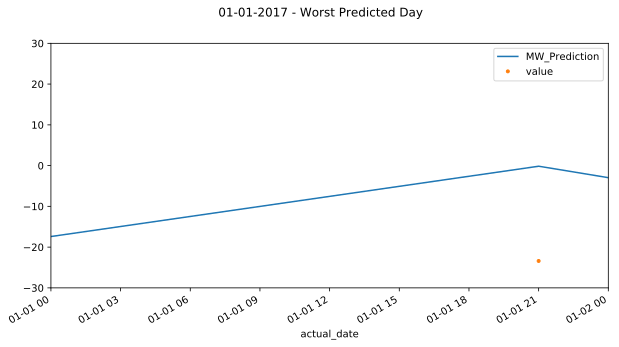

In [57]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','value']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(-30, 30)
ax.set_xbound(lower='01-01-2017', upper='01-02-2017')
plot = plt.suptitle('01-01-2017 - Worst Predicted Day')

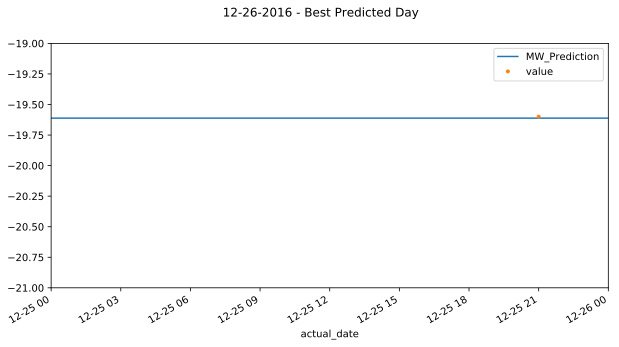

In [63]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','value']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(-21, -19)
ax.set_xbound(lower='12-25-2015', upper='12-26-2015')
plot = plt.suptitle('12-26-2016 - Best Predicted Day')